In [54]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.signal import butter, lfilter, filtfilt
import matplotlib.pyplot as plt

# Generating ratios from EEG

In [26]:
# Define the Butterworth bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Define the Butterworth high-pass filter function
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Apply the bandpass filter
def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Apply the high-pass filter
def apply_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def compute_ratios(csv_file_path):
    id = os.path.basename(csv_file_path).split('_')[0]
    type = os.path.basename(csv_file_path).split('_')[1]
    type = os.path.splitext(type)[0]
    
    data_df = pd.read_csv(csv_file_path)
    data_df.columns = data_df.columns.str.strip()  # Clean column names
    channels_data = data_df[['TP9', 'AF7', 'AF8', 'TP10']]

    sampling_frequency = 256  # Hz
    fft_size = 256
    frequency = np.fft.fftfreq(fft_size, 1 / sampling_frequency)
    alpha_band = (frequency >= 8) & (frequency <= 12)
    beta_band = (frequency > 12) & (frequency <= 30)
    theta_band = (frequency >= 4) & (frequency <= 8)
    gamma_band = (frequency > 30) & (frequency <= 50)

    for column in channels_data.columns:
        channels_data.loc[:,column] = apply_highpass_filter(channels_data[column], 1, sampling_frequency)

    # To store the computed powers for each band
    alpha_powers = []
    beta_powers = []
    theta_powers = []
    gamma_powers = []

    for channel in channels_data.columns:
        channel_data = channels_data[channel]
        filtered_data_theta = apply_bandpass_filter(channel_data, 4, 8, sampling_frequency)
        filtered_data_alpha = apply_bandpass_filter(channel_data, 8, 12, sampling_frequency)
        filtered_data_beta = apply_bandpass_filter(channel_data, 13, 30, sampling_frequency)
        filtered_data_gamma = apply_bandpass_filter(channel_data, 30, 50, sampling_frequency)

        spectrum_alpha = np.fft.fft(filtered_data_alpha, fft_size)
        spectrum_beta = np.fft.fft(filtered_data_beta, fft_size)
        spectrum_theta = np.fft.fft(filtered_data_theta, fft_size)
        spectrum_gamma = np.fft.fft(filtered_data_gamma, fft_size)

        power_alpha = np.abs(spectrum_alpha)**2
        power_beta = np.abs(spectrum_beta)**2
        power_theta = np.abs(spectrum_theta)**2
        power_gamma = np.abs(spectrum_gamma)**2
        total_power = np.sum(np.abs(np.fft.fft(channel_data, fft_size))**2)

        relative_power_alpha = np.sum(power_alpha[alpha_band]) / total_power
        relative_power_beta = np.sum(power_beta[beta_band]) / total_power
        relative_power_theta = np.sum(power_theta[theta_band]) / total_power
        relative_power_gamma = np.sum(power_gamma[gamma_band]) / total_power

        # Append relative powers separately for each band
        alpha_powers.append(relative_power_alpha)
        beta_powers.append(relative_power_beta)
        theta_powers.append(relative_power_theta)
        gamma_powers.append(relative_power_gamma)
        
    # Calcualte overall power of AF7 and AF8
    af7_data = channels_data['AF7']
    af8_data = channels_data['AF8']
    fft_af7 = np.fft.fft(af7_data, fft_size)
    fft_af8 = np.fft.fft(af8_data, fft_size)
    power_af7 = np.abs(fft_af7)**2
    power_af8 = np.abs(fft_af8)**2
    total_power_af7 = np.sum(power_af7)
    total_power_af8 = np.sum(power_af8)


    theta_beta_ratio = np.mean(theta_powers) / np.mean(beta_powers)
    alpha_beta_ratio = np.mean(alpha_powers) / np.mean(beta_powers)
    beta_theta_ratio = np.mean(beta_powers) / np.mean(theta_powers)
    beta_alpha_ratio = np.mean(beta_powers) / np.mean(alpha_powers)
    gamma_beta_ratio = np.mean(gamma_powers) / np.mean(beta_powers)
    frontal_alpha_asymmetry = np.log(total_power_af7) - np.log(total_power_af8)  

    result = {
        "id": id,
        f"Theta/Beta Ratio {type}": theta_beta_ratio,
        f"Alpha/Beta Ratio {type}": alpha_beta_ratio,
        f"Beta/Theta Ratio {type}": beta_theta_ratio,
        f"Beta/Alpha Ratio {type}": beta_alpha_ratio,
        f"Gamma/Beta Ratio {type}": gamma_beta_ratio,
        f"Frontal Alpha Asymmetry {type}": frontal_alpha_asymmetry,
    }
    return result


In [28]:
files = glob.glob("./EEG/*.csv")
results = []
columns = []
for file in files:
    ratios = compute_ratios(file)
    results.append(ratios)
    columns.extend(ratios.keys())
columns = list(set(columns))

In [32]:
# columns
results_df = pd.DataFrame(results, columns=columns)
results_df = results_df.set_index('id')

In [44]:
results_df.groupby('id').sum().replace(0, np.nan).to_csv(os.path.abspath('./results/ratios.csv'))

# Analsysing EEGs through Plots and tables

In [52]:
ratios_data = pd.read_csv(os.path.abspath('./results/ratios.csv'))

In [59]:
ratio_copy = ratios_data.copy()
ratio_copy.drop(columns= ["id"])
ratios_grouped = ratio_copy.groupby("Group").mean()
ratios_grouped.columns

Index(['id', 'Theta/Beta Ratio dur', 'Beta/Theta Ratio dur',
       'Frontal Alpha Asymmetry dur', 'Alpha/Beta Ratio dur',
       'Alpha/Beta Ratio post', 'Frontal Alpha Asymmetry pre',
       'Theta/Beta Ratio pre', 'Gamma/Beta Ratio post', 'Gamma/Beta Ratio dur',
       'Beta/Theta Ratio pre', 'Theta/Beta Ratio post', 'Alpha/Beta Ratio pre',
       'Frontal Alpha Asymmetry post', 'Beta/Alpha Ratio post',
       'Gamma/Beta Ratio pre', 'Beta/Alpha Ratio pre', 'Beta/Alpha Ratio dur',
       'Beta/Theta Ratio post'],
      dtype='object')

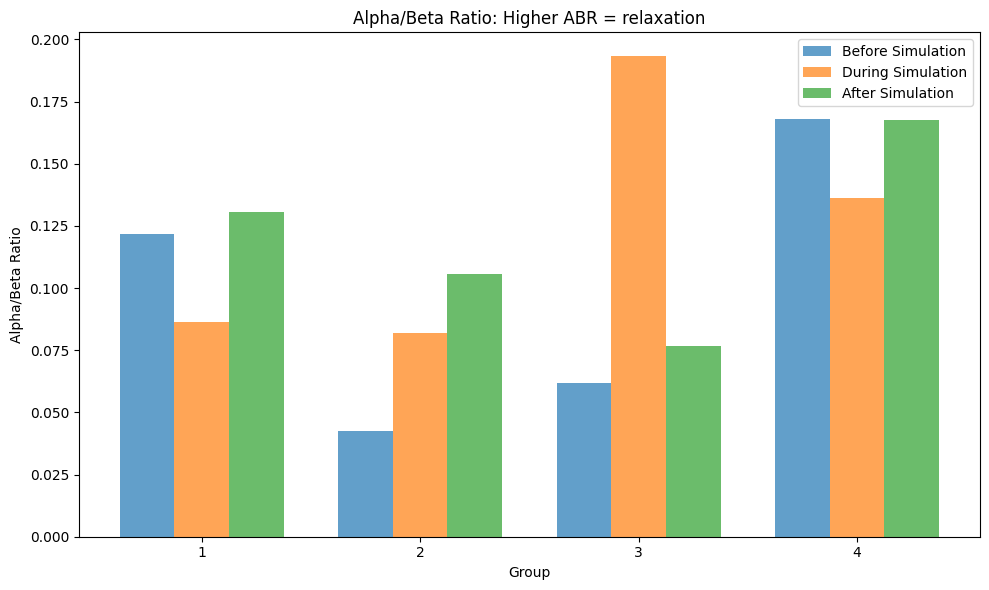

In [77]:
# plt.bar(["Alpha/Beta Ratio dur", "Alpha/Beta Ratio pre", "Alpha/Beta Ratio post"], ratios_grouped[["Alpha/Beta Ratio dur", "Alpha/Beta Ratio pre", "Alpha/Beta Ratio post"]])
# Plot Alpha/Beta Ratio for dur, pre and post in a side-by-side bar graph
x = np.arange(len(ratios_grouped.index))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Alpha/Beta Ratio pre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Alpha/Beta Ratio dur"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Alpha/Beta Ratio post"], width, label="After Simulation", alpha=0.7)

plt.xlabel("Group")
plt.ylabel("Alpha/Beta Ratio")
plt.title("Alpha/Beta Ratio: Higher ABR = relaxation")
plt.xticks(x, ratios_grouped.index)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
x = np.arange(len(ratios_grouped.index))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Theta/Beta Ratio pre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Theta/Beta Ratio dur"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Theta/Beta Ratio post"], width, label="After Simulation", alpha=0.7)

plt.xlabel("Group")
plt.ylabel("Theta/Beta Ratio")
plt.title("Theta/Beta Ratio: Higher TBR = higher stress")
plt.xticks(x, ratios_grouped.index)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
ratios_grouped[]

,Theta/Beta Ratio dur,Theta/Beta Ratio pre,Theta/Beta Ratio post
Group,,,
1,0.151061,0.309532,0.419586
2,0.247206,0.176917,0.256671
3,0.282949,0.145942,0.171858
4,0.410872,0.411402,0.336430
